<center>
<a href="https://colab.research.google.com/drive/178b8uBxnt_w0H7IAHlINXUOyo6uBqzhE?usp=sharing">
<img src="https://camo.githubusercontent.com/84f0493939e0c4de4e6dbe113251b4bfb5353e57134ffd9fcab6b8714514d4d1/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667"></a>
</center>

# Sample Neural Network, Part 2: Bias and CE Loss

*Note: To execute anything in this, you should first save your own copy to Google Drive.*

When using a artificial neurons to fit a curve (or function), we have several choices for potentially improving its behavior.  Among these
are 
1. Adding more layers to the network
2. Add a bias term
3. Try a different loss function

We looked at 1 previously, in this lesson we'll look at the second two.

## 1. Add a bias term
Recall that an artificial neuron consistis of a weighted sum that is then "run through" some nonlinear "activation" function. Our weighted sums that we looked at before did not (intentionally) include any constant offset or "bias" term.  This may be fine for some data, but not for many others.
For example, in a simple linear model $y = mx+b$, the choice of $b=0$ limits the model's ability to accurately fit some data.  

![image of bias vs no biast](https://i.imgur.com/5CbsjVW.png)

If we consider a 2-dimensional matrix $X$ that represents rows of data points, where the feature of each point are found in the columns.  We could write a given element of the matrix as $X_{ij}$ where $i$ is the column number and $j$ is the row number.  And then the weight of sum with a neuron numbered $j$ could be $w_j$.  If we consider 
sums like $\sum_j X_{ij}w_j$, there no constant offset to handle the case where a particular value of $X_{ij}$ is zero.  To correct this, we could add a new variable $b$ and make our weighted sum $b + \sum_j X_{ij}w_j$.  Equivalently, and more conveniently for the purposes of coding, we could put an additional column of 1's in the input $X$, and a new row to our weight matrix $w$.  By convention, this is usually done with the zeroth element, so that $X_{i0}=1$ and the columns of $X$ are moved to the right, and $w_0 = b$ will be the new constant offset (because $1*w_0 = w_0$.)

For the first problem (Trask's first problem), this change makes our new matrix equation look like (with new bias terms in red)


$$
f\left(
  \overbrace{
 \left[ {\begin{array}{ccc}
   \color{red}1 & 0 & 0 & 1 \\
   \color{red}1 & 0 & 1 & 1\\
   \color{red}1 & 1 & 0 & 1\\
   \color{red}1 & 1 & 1 & 1\\
  \end{array} } \right]
}^\text{X} 
\overbrace{
   \left[ {\begin{array}{c}
   \color{red}{w_0}  \\
    w_1\\
   w_2\\
   w_3
  \end{array} } \right]
 }^{w}
\right)
  = 
  \overbrace{
 \left[ {\begin{array}{c}
   0   \\
   0  \\
   1  \\
   1 \\
  \end{array} } \right]
 }^{\tilde{Y}}
$$
***Foreshadowing***: *Note that in this problem, the rightmost column of $X$ already was a column of all 1's, and so already has something akin to a bias.  Thus, adding a new column of all 1's will not add any information, and so for this problem we expect that adding the bias won't improve the model performance.)*

With this change, we can still write our weighted sum as $\sum_j X_{ij}w_j$, it's just that $j$ now runs  over 0 to 3 instead of 0 to 2. When we do this, our actual code will be the same as before, provided we change $X$ by adding a column of 1's and include one more weight. 

In terms of coding the change to $X$, we can either rewrite it by hand, or pull a numpy trick:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# old data
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
print("X = \n",X)

# add a column of 1's
new_col = np.ones((X.shape[0],1)) # array of 1s, w/ same # of rows as X, 1 col wide
X_bias = np.hstack((new_col,X))   # "hstack" = stack them horizontally

print("X_bias = \n",X_bias)


X = 
 [[0 0 1]
 [0 1 1]
 [1 0 1]
 [1 1 1]]
X_bias = 
 [[1. 0. 0. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 1.]]


Sometimes the inclusion of bias doesn't make any significant difference but other times it can.  By default, bias in "on" in PyTorch (as `use_bias=True` when defining `nn.Linear` layers.).  As a sample problem, let's try the same thing for trying to learn to map the digits of a seven segment display.  And we're going to do it in raw Numpy so we can see all the parts!



## Exercise: Read a 7-segment display

A [7-segment display](https://en.wikipedia.org/wiki/Seven-segment_display) is used for displaying numerical digits 0 through 9, usually by lighting up LEDs or parts of a liquid crystal display (LCD).  The segments are labelled $a$ through $g$ according to the following diagram:

![7-segment diagram](https://i.imgur.com/ZyHGDKy.png =100x150) 

### Diagram of the network
The 7 inputs "a" through "g" will be mapped to 10 outputs for the individual digits, and each output can range from 0 ("false" or "no") to 1 ("true" or "yes") for that digit.  The input and outputs will be connected by a matrix of weights.  Pictorially, this looks like the following (Not shown: activation function $f$):

![diagram of 7-seg network](https://i.imgur.com/mERzmFE.png)

...where again, this network operates on a single data point at a time, datapoints which are *rows* of *X* and *Y*.  What is shown in the above diagram are the *columns* of $X$ and $Y$ for a single row (/ single data point).

### Create the dataset
Let the input X be the segments $a$ through $g$ are the columns of the input $X$, and are either 1 for on or 0 for off.  Let the columns of the target $Y$ be the digits 0-9 themselves arranged in a ["one hot" encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) scheme, as follows:


<table>
  <tr><td>Digit</td><td>One-Hot Encoding for $Y$</td></tr>
    <tr><td>0</td><td>1,0,0,0,0,0,0,0,0,0</td></tr>
    <tr><td>1</td><td>0,1,0,0,0,0,0,0,0,0</td></tr>
    <tr><td>2</td><td>0,0,1,0,0,0,0,0,0,0</td></tr>
  <tr><td>...</td><td>...</td></tr>
    <tr><td>9</td><td>0,0,0,0,0,0,0,0,0,1</td></tr>
  </table>
  ...where the missing values are left as part of the exercise, for you to fill in! 

  The values in the columns for $Y$ are essentially true/false "bits" for each digit, answering the question "Is this digit the appropriate output?" with a "yes"(=1) or "no" (=0) response. 

The input $X$ will be a 10x7 matrix, and the target $Y$ will be a 10x10 matrix. Each row of $X$ will be the segments to produce the digit for that row.  For example, the zeroth row of $X$ should show segments on which make an image of the digit zero, namely segments a, b, c, d, e, and f but not g, so that the zeroth row of X should be [1,1,1,1,1,1,0].


You'll want to define numpy arrays for both $X$ and $Y$  (Hint: for $Y$, check out [np.eye()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html)): 


In [ ]:
# Students: fill these out completely for what the X and Y *should* be
# for the 7-segment display.  The following is just a "stub" to get you started.
 # there should be 7 coolumns (for segments a through g) and 10 rows (for 0-9)
 X_7seg_no_bias = np.array([
                    #a b c d e f g 
                    [1,1,1,1,1,1,0],  # 0
                    [0,1,1,0,0,0,0],  # 1 
                    [1,1,0,1,1,0,1],  # 2
                    #
                    # fill in the missing rows for the remaining digits, 
                    #
                    [1,1,1,0,0,0,0],  # 7 
                    [1,1,1,1,1,1,1],  # 8 
                    [1,1,1,1,0,1,1]   # 9 
                 ])
Y = np.array([ [1,0,0,0,0,0,0,0,0,0],  # we need ten "one-hot encoded" rows
               [],... # fill in the rest or use np.eye()
               [] ])

To add a bias to the inpux X, we just add a feature of "1" to each data point -- i.e. we add a column full of ones.  We can put it at the beginning or the end. We'll put it at the beginning.

In [40]:
X = np.array([ [1,1,1,1,1,1,0,1],  # 0
                    [0,1,1,0,0,0,0,1],  # 1 
                    [1,1,0,1,1,0,1,1],  # 2
                    [1,1,1,1,0,0,1,1],  # 3
                    [0,1,1,0,0,1,1,1],  # 4 
                    [1,0,1,1,0,1,1,1],  # 5
                    [1,0,1,1,1,1,1,1],  # 6 
                    [1,1,1,0,0,0,0,1],  # 7 
                    [1,1,1,1,1,1,1,1],  # 8 
                    [1,1,1,1,0,1,1,1]   # 9 
                 ])

In [41]:
new_col = np.ones((X.shape[0],1)) # array of 1s, w/ same # of rows as X, 1 col wide
X_7seg_bias = np.hstack((new_col,X))   # "hstack" = stack them horizontally
Y_7seg = np.eye(10)

X, Y = X_7seg_bias, Y_7seg      # X will be our inputs, Y will be out outputs

We're going to build a routine to fit a curve via Gradient Descent.  This means that we use the *derivative* of *loss* function to nudge the *weights* a bit so that *next time* the loss will be smaller.

Well define a loss function and a couple activations and then build the fit function below

In [102]:
def sigmoid(x,deriv=False):  # can get the derivative by setting deriv=True
  if(deriv==True):
    return x*(1-x)
  return 1/(1+np.exp(-x))

def relu(x,deriv=False):   # relu activation
  if(deriv==True):
    return 1*(x>0) 
  return x*(x>0)

The loss function will be Mean Squared Error (MSE) loss, which is defined for targets $y_i$ and predictions $\tilde{y_i}$ as:

$$ MSE = {1\over N}\sum_{i=0}^N (\tilde{y_i} - y_i)^2 $$
where $\tilde{y}_i$ = $f(w\cdot X)$
and its gradient (or derivative) with respect to $w$ is just given by the power rule for the exponent 2 -- then multiplied by the derivative of the activation function with respect to $w$!)

In [ ]:
def calc_loss(Y_pred, Y, X, w, activ, loss_type="mse"):  # Mean Squared Error (MSE) loss
    diff = Y_pred - Y
    loss = (diff**2).mean()
    # for weight update. Note we use X.T instead of X "to make the inner dimensions match" in the matrix multiply
    gradient = np.dot( X.T, diff*activ(Y_pred, deriv=True))
    return loss, gradient   # return the loss and its gradient

The following is a little routine that will fit $X$ to $Y$ by taking little nudges via the gradient.  The size of each nudge will be scaled by the "learning rate" $\alpha$.  (It will handle adding bias or not to our inputs $X$ so we don't have to.)

In [133]:
def fit(X, Y, activ, use_bias=True, alpha=3.0, maxiter=10000, loss_type='mse'):
  """
  fit: Generic routine for doing our gradient decent

  Required arguments:
      X:     input matrix
      Y:     target output
      activ: reference to an activation function
      
  Keywork arguments (optional):
      use_bias: Flag for whether to use bias in the model
      alpha:    learning rate. Tip: Use the largest alpha 'you can get away with'
      maxiter:  maximum number of iterations
      loss_type: Set to MSE for now but we'll extend this later. 
  """
  if use_bias:                       # add a column of 1's to X
    new_col = np.ones((X.shape[0],1)) 
    X = np.hstack((new_col,X))        

  # define weights for a zero-hiddne-layer network (See diagram above)
  np.random.seed(1)                  # set the RNG for reproducibility 
  if activ == sigmoid:
    w = (2*np.random.random((X.shape[1],Y.shape[1])) - 1)/10  # rand # in range -.1 to .1 
  else:
    w = np.random.random((X.shape[1],Y.shape[1]))/10  # only positive weights (for later)


  loss_hist = []                     # remember loss values as we train so we can plot them later
  # training loop begins here
  for iter in range(maxiter):

    Y_pred = activ(np.dot(X,w))      # compute prediction/inference, i.e. tilde{Y}

    loss, gradient = calc_loss(Y_pred, Y, X, w, activ, loss_type)
    loss_hist.append(loss)           # add to the history of the loss
    
    w -= alpha * gradient            # Gradient Descent update to the weights; minus sign = downward!

  return w, Y_pred, loss_hist        # send back weights, predictions, and history of loss during training

In [134]:
# define a helper function to let us plot a little more concisely
def plot_it(loss_hist, label):
    plt.loglog(loss_hist, label=f"{activ}, bias={bias}")
    plt.xlabel("Iteration")
    plt.ylabel("MSE Loss")
    plt.legend()

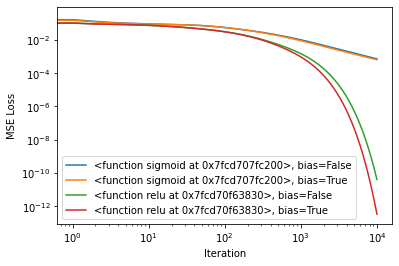

In [152]:
# Call the fit routine for various choices of activation or bias
#X = X+np.mean(X)
for activ in [sigmoid, relu]:
    for bias in [False, True]:
        alpha = 0.1 if activ == sigmoid else 0.01    # assign learning rate
        w, Y_pred, loss_hist = fit(X, Y, activ, alpha=alpha, use_bias=bias)
        plot_it(loss_hist, label=f"{activ}, bias={bias}")

...So, actually the bias doesn't make much of a difference in this case!   

And it looks like ReLU clearly "wins", BUT!  What happens if X is not all positive? Say we subtract the mean of X before sending it in to the network?

 activ =  <function sigmoid at 0x7fcd707fc200> , bias = False
 activ =  <function sigmoid at 0x7fcd707fc200> , bias = True
 activ =  <function relu at 0x7fcd70f63830> , bias = False
 activ =  <function relu at 0x7fcd70f63830> , bias = True


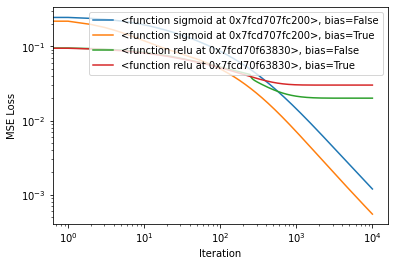

In [154]:
for activ in [sigmoid, relu]:
    for bias in [False, True]:
        print(" activ = ",activ,", bias =",bias)
        alpha = 0.1 if activ == sigmoid else 0.01    # assign learning rate
        w, Y_pred, loss_hist = fit((X-X.mean()), Y, activ, alpha=alpha, use_bias=bias)
        plot_it(loss_hist, label=f"{activ}, bias={bias}")
plt.show()

Why might the ReLU have "checked out"?

Also notice that this time the bias made a difference for the sigmoid at least.

...So for this problem, it seems that adding the bias gave us a bit more accuracy, both for the sigmoid and relu activations.  *Note: in this example, the learning rates were chosen by experiment; you should get in the habit of going back and experimenting with different learning rates.*  


## Video Interlude: Logistic Regression
What we've been doing up until now has been a "classification" problem, with "yes"/"no" answers represented by 1's and 0's.  This sort of operation is closely associated with the statistical method of Logistic Regression.  It is akin to linear regression but with a sigmoid activation function.  When doing Logistic Regression, one optimizes to fit by finding the maximum "likelihood" of a given model being correct.  

To gain some insight on Logistic Regression, watch [this SatsQuest video](https://www.youtube.com/watch?v=yIYKR4sgzI8).  (You can ignore his remarks about his preceding video, "R squared" and "p-value", etc.)


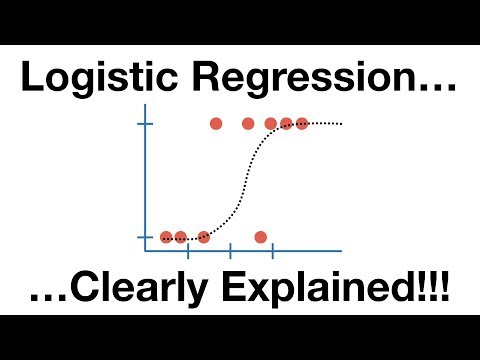

In [165]:
from IPython.display import YouTubeVideo
YouTubeVideo('yIYKR4sgzI8')

In what follows, we will be *minimizing* the *negative* of the *logarithm* of the likelihood, a quantity typically known as the Binary Cross-Entropy loss. (This same quantity is also the non-constant part of the "Kullback-Leibler Divergence" or "K-L divergence," so you may hear it called that sometimes.)


To futher explore the Binary Cross Entropy loss, explore this snarky algorithmic ethics take on Santa Claus' surveillance infrastructure, then come back when you're ready for more. 

https://hedges.belmont.edu/~shawley/naughty/

![preview of santa](https://hedges.belmont.edu/naughty/naughty2.png)


## 2. Use a different loss function: Binary Cross-Entropy loss

Let's return to Trask's first problem for which there is only one target per data point (row) of input, namely a target of 0 or 1.  In this case, using the sigmoid function for this classification problem is one of [logistic regression](https://www.youtube.com/watch?v=yIYKR4sgzI8), even though we hadn't it identified it as such. 

We've been using mean squared error (MSE) loss, but other loss functions exist.  In particular, for outputs which are either "yes" or "no" such as the *classification problem* we are solving, a function called "[cross entropy](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy)" is typically preferred. The cross-entropy loss is written like this:

$$L_{CE} = -\sum_i \left[ Y_i\log(\tilde{Y}_i) + (1-Y_i)\log(1-\tilde{Y}_i) \right]$$

Note that since the function $\log(x)$  is undefined for $x\le0$, we need to make sure $0<\tilde{Y}_i<1$ for all $i$.  One way to ensure this is to use sigmoid activation! Thus, for classification problems, it is very common to see sigmoid activation (or its multi-class relative "[softmax](http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/)") immediately before the output, even for many-layer neural networks with all kinds of other activations in other places. 






To use the CE loss with gradient descent, we need its derivative with respect to the weights. First let's write the CE loss in terms of the inputs $X$, weights $w$ and activation function $f$:

...wait, for compactness, let's write the weighted sum as $S_i = \sum_j X_{ij}w_j$. Ok, now going forward....

$$L_{CE} = -\sum_i\left[ Y_i\log\left(f\left(S_i \right)\right) + (1-Y_i)\log\left(1- f\left(S_{i}\right)\right) \right]$$

For any function $g(x)$, the derivative of $\log(g(x))$ with respect to x is just $1/g*(du/dx)$, so our partial derivatives with respect to weights look like

$${\partial L_{CE}\over \partial w_j} = -\sum_i\left[ {Y_i\over\tilde{Y_i}}{\partial f(S_i)\over \partial w_j}  - 
{1-Y_i\over 1-\tilde{Y}_i} {\partial f(S_i)\over \partial w_j} \right]\\
= -\sum_i {\partial f(S_i) \over \partial S_i}{\partial S_i\over\partial w_j} \left[  {Y_i\over\tilde{Y_i}}  - 
{1-Y_i\over 1-\tilde{Y}_i}  \right]
$$
And if we multiply by $2/N$, we can write this as
$$
{\partial L_{CE}\over \partial w_j}
= {2\over N} \sum_{i=0}^{N-1}  {\partial f(S_i) \over \partial S_i}X_{ij}
\left[
{\tilde{Y_i}-Y_i\over \tilde{Y_i}(1-\tilde{Y_i}) }\right]$$
This is similar to the partial derivatives for our MSE loss, except the term in the denominator is new.  To see this more clearly, 
recall that the weight update for  MSE (from Part 1) was
$$
w := w - \alpha  X^T \cdot \left( [\tilde{Y}-Y]*\tilde{Y}*(1-\tilde{Y})\right)
$$
whereas for CE we actually get a bit of a simplification because the term in the denominator cancels with a similar term in the numerator:
$$
w := w - \alpha  X^T \cdot \left( [\tilde{Y}-Y]*\tilde{Y}*(1-\tilde{Y})\right) / (\tilde{Y}*(1-\tilde{Y})) \\
w := w - \alpha  X^T \cdot [\tilde{Y}-Y].
$$
Thus despite all this seeming complication, our CE weight update is actually simpler than what it was before as MSE!

Let's try this out with code now:

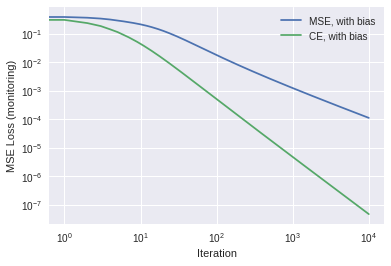

MSE _loss: Y_pred =
 [[0.01]
 [0.01]
 [0.99]
 [0.99]]
CE loss: Y_pred =
 [[0.00]
 [0.00]
 [1.00]
 [1.00]]


In [ ]:
# we'll "overwrite" the earlier calc_loss function
def calc_loss(Y_pred, Y, X, w, activ, loss_type='ce'):
  diff = Y_pred - Y
  loss = (diff**2).mean()         # MSE loss

  if 'ce' == loss_type:
    diff = diff / (Y_pred*(1-Y_pred))     # use this for gradient
    #loss = -(Y*np.log(Y_tilde) + (1-Y)*np.log1p(-Y_tilde)).mean()  # CE Loss
    #  Actually we don't care what the loss itself is. 
    #  Let's use MSE loss for 'monitoring' regardless, so we can compare the 
    #  effects of using different gradients-of-loss functions

  gradient = np.dot( X.T, diff*activ(Y_pred, deriv=True))      # same as before
  return loss, gradient

#---- 
X = X_bias
Y = np.array([[0,0,1,1]]).T  # target output dataset 

# Compare old and new
w_mse, Y_pred_mse, loss_hist_mse = fit(X, Y, sigmoid, alpha=0.5, loss_type='mse')  
w_ce, Y_pred_ce, loss_hist_ce    = fit(X, Y, sigmoid, alpha=0.5, loss_type='ce')   # fit

plot_new_old(loss_hist_mse, loss_hist_ce, ["MSE, with bias", "CE, with bias"])
# And print the final answers:
print("MSE _loss: Y_pred =\n",Y_pred_mse)
print("CE loss: Y_pred =\n",Y_pred_ce)

This works a lot better!  To understand why, note that the gradients for MSE loss scale like
$$[\tilde{Y}-Y]*\tilde{Y}*(1-\tilde{Y})$$ and thus **these gradients go to zero** as $\tilde{Y}\rightarrow 0$, and/or $\tilde{Y}\rightarrow 1$, which makes training **very slow**!   In contrast, the extra denominator in the CE gradients effectively cancels out this behavior, leaving the remaining term of 
$$[\tilde{Y}-Y]$$ which varies *linearly* with the difference from the target value. This makes training much more efficient. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


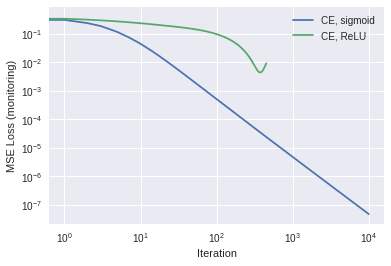

In [ ]:
# Aside: What happens if we try ReLU activation with CE loss?  Bad things, probably.
# Recall that ReLU maps negative numbers to 0, and isn't bounded from above.
#  Thus the "denominator" in the 'diff term' in our earlier code will tend to 'explode'.  
#  Put differently, note that log(x) is undefined for x=0, as is log(1-x) for x=1.
w_relu_ce, Y_pred_relu_ce, loss_hist_relu_ce = fit(X, Y, relu, alpha=0.001, loss_type='ce') 
plot_new_old(loss_hist_ce, loss_hist_relu_ce, ["CE, sigmoid", "CE, ReLU"])

# Excercise: 
Do the same comparison for the 7-segment display problem: Make a plot showing a comparison of the loss history use MSE loss vs. using CE loss. And print out the final values of `Y_pred` for each.  Use a learning rate of 0.5 and sigmoid activation, with bias. 

Take a screenshot of the output and upload it to your instructor.

(*Note:* for the 7-segment display, since the target $Y$ has multiple columns, we should "normalize" the output in order to be able to properly interpret the output values $\tilde{Y}$ as probabilities. To do so, we would use a `softmax` activation. For now, we haven't bothered with this because it would add a bit more math, and is not actually necessary to solve this problem. )